# Boston COVID19

Recently Boston became a covid19 hotspot due to an outbreak occurring at biogen. This happens to be a company located approximately 2 blocks from my apartment. We share restaurants, transit hubs and more. Since this hits a little close to home, I wanted to take a look at the suspected growth rate for the total possible number of infected people in the boston area.

To do this, we will use the SIR model and we can also create a forecasting model using prophet to track the predicted vs. actual. 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates
from sklearn.cluster import KMeans
import datetime
from datetime import date, timedelta
from fbprophet import Prophet
from datetime import datetime

In [17]:
df=pd.read_csv("covid19_clean_complete.csv", parse_dates=True)

In [32]:
df['Date'] = df['Date'].apply(lambda x: datetime.strptime(x, '%m/%d/%y'))

In [33]:
df.groupby('Country/Region').sum()

,Lat,Long,Confirmed,Deaths,Recovered
Country/Region,,,,,
Afghanistan,1683.0000,3315.0000,40,0,0
Albania,2098.8183,1028.5833,47,2,0
Algeria,1429.7289,84.6396,175,1,8
Andorra,2167.8213,77.6118,11,0,1
Argentina,-1959.2211,-3244.4517,92,5,0
...,...,...,...,...,...
US,104702.5716,-237483.7848,4614,104,28
Ukraine,2467.3494,1589.4456,10,0,0
United Arab Emirates,1224.0000,2754.0000,802,0,161


In [63]:
agg_df = df[(df['Country/Region']=='US') & (df['Province/State'] == 'Massachusetts')].groupby('Date').sum()
agg_df.sort_values('Date',inplace=True)

In [65]:
agg_df.tail()

,Lat,Long,Confirmed,Deaths,Recovered
Date,,,,,
2020-03-08,42.2302,-71.5301,0,0,0
2020-03-09,42.2302,-71.5301,0,0,0
2020-03-10,42.2302,-71.5301,92,0,1
2020-03-11,42.2302,-71.5301,95,0,1
2020-03-12,42.2302,-71.5301,108,0,1


## Modeling the growth of a region

Since we don't have a lot of data for Boston, we can use SIR as a model to estimate the growth in the area.

We will make some assumptions around the population because it is most likely feasible that only certain mobile areas of the greater boston population would be affected. In addition, since schools have closed and work from home is already mandated, we can probably further reduce our contact rate to the lower of the range shown for the coronavirus.

In [46]:
population = 4875390
saturation_coeff = .5 # estimated possible population saturation
density_coeff=.5 # 1/3 of wuhan

# Using the SIR model to determine growth

* recovery rate, gamma = 1/7 - 1 person takes on average 7 days to recover and will be contagious
* contact rate, beta = .5 - This is difficult because it varies over time [1](https://www.sciencedirect.com/science/article/pii/S246804272030004X). This complicates things, since the early contact rate could be up to 10, but will decrease as restrictions are placed on the population, people self-isolate etc. For this estimation we will assume a contact rate of 0.5 on average. 


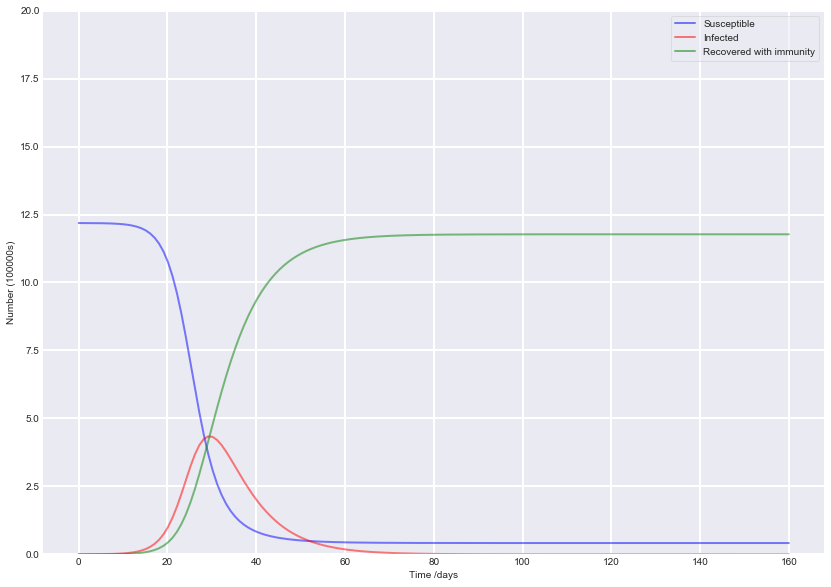

targeted population in this model: 1218847.5
critical infected population at inflection point: 433782.41360715934


In [62]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt

# Total population adjusted for assumptions listed above
N = population * saturation_coeff * density_coeff
# Initial number of infected and recovered individuals, I0 and R0.
I0, R0 = 91, 1
# Everyone else, S0, is susceptible to infection initially.
S0 = N - I0 - R0
# Contact rate, beta, and mean recovery rate, gamma, (in 1/days).
beta, gamma = .5, 1/7 
# A grid of time points (in days)
t = np.linspace(0, 160, 160)

# The SIR model differential equations.
def deriv(y, t, N, beta, gamma):
    S, I, R = y
    dSdt = -beta * S * I / N
    dIdt = beta * S * I / N - gamma * I
    dRdt = gamma * I
    return dSdt, dIdt, dRdt

# Initial conditions vector
y0 = S0, I0, R0
# Integrate the SIR equations over the time grid, t.
ret = odeint(deriv, y0, t, args=(N, beta, gamma))
S, I, R = ret.T

# Plot the data on three separate curves for S(t), I(t) and R(t)
fig = plt.figure(facecolor='w', figsize= (14,10))
ax = fig.add_subplot(111, axisbelow=True)
ax.plot(t, S/100000, 'b', alpha=0.5, lw=2, label='Susceptible')
ax.plot(t, I/100000, 'r', alpha=0.5, lw=2, label='Infected')
ax.plot(t, R/100000, 'g', alpha=0.5, lw=2, label='Recovered with immunity')
ax.set_xlabel('Time /days')
ax.set_ylabel('Number (100000s)')
ax.set_ylim(0,20)
ax.yaxis.set_tick_params(length=0)
ax.xaxis.set_tick_params(length=0)
ax.grid(b=True, which='major', c='w', lw=2, ls='-')
legend = ax.legend()
legend.get_frame().set_alpha(0.5)
for spine in ('top', 'right', 'bottom', 'left'):
    ax.spines[spine].set_visible(False)
plt.show()
print("targeted population in this model: {}".format(N))
print("critical infected population at inflection point: {}".format(I.max()))